In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spatial
import itertools
from astropy.table import Table
import pandas as pd
import sys

In [2]:
def web_classification(n_data, n_random):
    assert len(n_data) == len(n_random)
    n_points = len(n_data)
    r_values = (n_data-n_random)/(n_data+n_random)
    web_class = np.zeros(n_points, dtype=int)
    lower_limit = -0.80
    upper_limit = 0.80
    is_void = r_values <= lower_limit
    is_sheet = (r_values > lower_limit) & (r_values<=0.0)
    is_filament = (r_values>0.0) & (r_values <= upper_limit)
    is_peak = (r_values > upper_limit)
    web_class[is_void] = 0
    web_class[is_sheet] = 1
    web_class[is_filament] = 2
    web_class[is_peak] = 3
    return web_class  

In [3]:
def find_environment(rosette_id=0, random_id=0):
    # read data
    radec_filename = "../data/radec_rosette_{}_data.csv".format(rosette_id)
    data_filename = "../data/xyz_rosette_{}_data.csv".format(rosette_id)
    random_filename = "../data/xyz_rosette_{}_random_{}.csv".format(rosette_id, random_id)
    web_filename = "../data/web_rosette_{}_random_{}.csv".format(rosette_id, random_id)

    # stack data and run Delaunay Tessellation.
    data = pd.read_csv(data_filename)
    random = pd.read_csv(random_filename)
    n_d = len(data)
    n_r = len(random)
    assert n_d==n_r
    print(n_d)
    points = np.vstack([data[['X','Y','Z']], random[['X', 'Y', 'Z']]])
    tri = spatial.Delaunay(points)
    
    #find all pairs
    all_pairs = []
    for simplex in tri.simplices:
        a = list(itertools.combinations(simplex,2))
        l = list(map(list, a))
        l = list(map(np.sort, l))
        l = list(map(list, l))
        all_pairs.append(l)
        
    all_pairs = np.vstack(all_pairs)
    print('all_pairs', np.shape(all_pairs))
    unique_pairs = np.unique(all_pairs, axis=0)
    print('unique_pairs', np.shape(unique_pairs))
    
    n_to_random = np.zeros(n_d+n_r)
    n_to_data = np.zeros(n_d+n_r)

    for p in unique_pairs:
        a = p[0]
        b = p[1]
        a_is_data = True
        b_is_data = True
        if a>=n_d:
            a_is_data = False
        if b>=n_d:
            b_is_data = False
        
        if a_is_data:
            n_to_data[b] +=1 
        else:
            n_to_random[b] +=1
    
        if b_is_data:
            n_to_data[a] +=1 
        else:
            n_to_random[a] +=1
            
    
    count_data = np.array([n_to_data[:n_d], n_to_random[:n_d]])
    count_random = np.array([n_to_data[n_d:], n_to_random[n_d:]])



    is_pairs_data = (unique_pairs[:,0]<n_d) & (unique_pairs[:,1]<n_d)
    is_pairs_random = (unique_pairs[:,0]>=n_d) & (unique_pairs[:,1]>=n_d)
    pairs_data = unique_pairs[is_pairs_data,:]
    pairs_random = unique_pairs[is_pairs_random,:]-n_d
    
    web_class = web_classification(count_data[0,:], count_data[1,:])
    
    data_rosette = pd.read_csv(radec_filename)
    data_rosette['WEB'] = web_class
    data_rosette.to_csv(web_filename, index=False)

In [4]:
for rosette_id in range(20):
    for random_id in range(15):
        print(rosette_id, random_id)
        find_environment(rosette_id=rosette_id, random_id=random_id)

0 0
2105
all_pairs (164928, 2)
unique_pairs (31810, 2)
0 1
2105
all_pairs (164424, 2)
unique_pairs (31722, 2)
0 2
2105
all_pairs (163518, 2)
unique_pairs (31574, 2)
0 3
2105
all_pairs (163878, 2)
unique_pairs (31621, 2)
0 4
2105
all_pairs (163398, 2)
unique_pairs (31554, 2)
0 5
2105
all_pairs (164052, 2)
unique_pairs (31665, 2)
0 6
2105
all_pairs (164130, 2)
unique_pairs (31677, 2)
0 7
2105
all_pairs (163350, 2)
unique_pairs (31548, 2)
0 8
2105
all_pairs (164298, 2)
unique_pairs (31703, 2)
0 9
2105
all_pairs (164070, 2)
unique_pairs (31654, 2)
0 10
2105
all_pairs (163674, 2)
unique_pairs (31592, 2)
0 11
2105
all_pairs (163878, 2)
unique_pairs (31644, 2)
0 12
2105
all_pairs (164178, 2)
unique_pairs (31675, 2)
0 13
2105
all_pairs (163920, 2)
unique_pairs (31653, 2)
0 14
2105
all_pairs (164190, 2)
unique_pairs (31692, 2)
1 0
3304
all_pairs (258546, 2)
unique_pairs (49819, 2)
1 1
3304
all_pairs (258786, 2)
unique_pairs (49887, 2)
1 2
3304
all_pairs (258774, 2)
unique_pairs (49884, 2)
1 3
3

In [5]:
def compute_environment_proba(rosette_id, n_random=15):
    all_env_data = {}
    envs = []
    for random_id in range(n_random):
        filename =  "../data/web_rosette_{}_random_{}.csv".format(rosette_id, random_id)
        all_env_data[random_id] = pd.read_csv(filename)
        #print(np.shape(all_env_data))
        
    n_objects = len(all_env_data[0]['WEB'])
    print(rosette_id, n_objects)
    webs = np.zeros((n_objects, n_random), dtype='int')
    proba = np.zeros((n_objects, 4))
    for i in range(n_random):
        webs[:,i] = all_env_data[i]['WEB']
    for i in range(n_objects):
        for j in range(4):
            ii = webs[i,:]==j
            proba[i,j] = 1.0*np.count_nonzero(ii)/n_random
    
    out_filename = "../data/p_web_rosette_{}.csv".format(rosette_id)
    data = pd.read_csv("../data/web_rosette_{}_random_{}.csv".format(rosette_id, 0))
    del data['WEB']
    data['P_VOID'] = proba[:,0]
    data['P_SHEET'] = proba[:,1]
    data['P_FILAMENT'] = proba[:,2]
    data['P_PEAK'] = proba[:,3]
    #print(data)
    data.to_csv(out_filename, index=False)
    return data
#for rosette_id in range(20):
#    for random_id in range(15):
#        print(rosette_id, random_id)
#        find_environment(rosette_id=rosette_id, random_id=random_id)

In [6]:
all_data = {}
for i in range(20):
    all_data[i] = compute_environment_proba(i)

0 2105
1 3304
2 2602
3 2616
4 2908
5 2632
6 2149
7 2314
8 2677
9 2967
10 2667
11 3237
12 2506
13 3565
14 2073
15 2151
16 2929
17 2714
18 2188
19 2266


(array([334., 130.,  89.,  66.,  81.,  88.,  82., 101., 101., 108., 133.,
        175., 202., 254., 341., 382.]),
 array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
        1.    ]),
 <BarContainer object of 16 artists>)

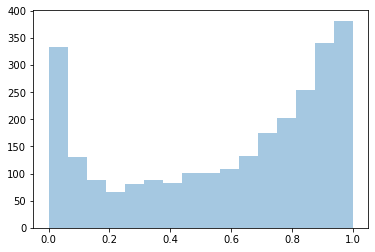

In [18]:
data = all_data[10]
#plt.hist(webs[:,0],  alpha=0.4)
#plt.hist(webs[:,1], alpha=0.4)
plt.hist(data['P_FILAMENT'], alpha=0.4, bins=16)
#plt.hist(webs[:,3], alpha=0.4)

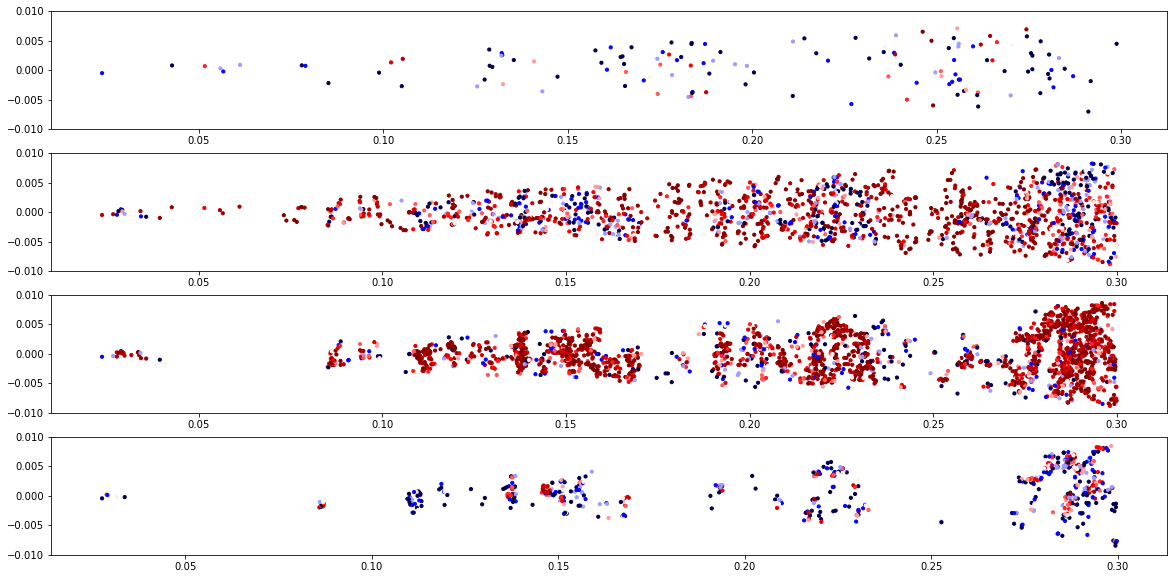

In [19]:
plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    #plt.scatter(data_rosette['RA'], data_rosette['DEC'], alpha=0.1)
    #plt.subplot(1,2,2, adjustable='box')

plt.subplot(4,1,1)
plt.scatter(data['Z'], 
                data['Z']*np.deg2rad(data['RA']-np.mean(data['RA'])), s=10, c=np.log10(data['P_VOID']), cmap='seismic')
plt.ylim(-0.01,0.01)


plt.subplot(4,1,2)
plt.scatter(data['Z'], 
                data['Z']*np.deg2rad(data['RA']-np.mean(data['RA'])), s=10, c=np.log10(data['P_SHEET']), cmap='seismic')
plt.ylim(-0.01,0.01)


plt.subplot(4,1,3)
plt.scatter(data['Z'], 
                data['Z']*np.deg2rad(data['RA']-np.mean(data['RA'])), s=10, c=np.log10(data['P_FILAMENT']), cmap='seismic')
plt.ylim(-0.01,0.01)

plt.subplot(4,1,4)
plt.scatter(data['Z'], 
                data['Z']*np.deg2rad(data['RA']-np.mean(data['RA'])), s=10, c=np.log10(data['P_PEAK']), cmap='seismic')
plt.ylim(-0.01,0.01)

plt.show()

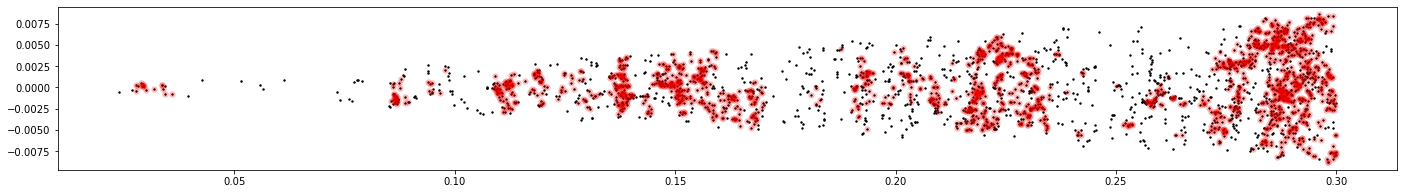

In [20]:
plt.figure(figsize=(24,3))
plt.scatter(data['Z'], data['Z']*np.deg2rad(data['RA']-np.mean(data['RA'])), s=2, c='black')#, cmap='seismic')
ii = data['P_FILAMENT']>0.5
plt.scatter(data['Z'][ii], data['Z'][ii]*np.deg2rad(data['RA'][ii]-np.mean(data['RA'])), s=30, c='red', alpha=0.2)#, cmap='seismic')


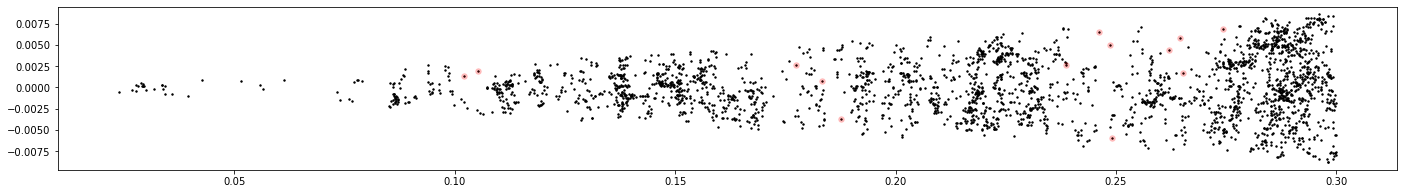

In [21]:
plt.figure(figsize=(24,3))
plt.scatter(data['Z'], data['Z']*np.deg2rad(data['RA']-np.mean(data['RA'])), s=2, c='black')#, cmap='seismic')
ii = data['P_VOID']>0.5
plt.scatter(data['Z'][ii], data['Z'][ii]*np.deg2rad(data['RA'][ii]-np.mean(data['RA'])), s=30, c='red', alpha=0.2)#, cmap='seismic')


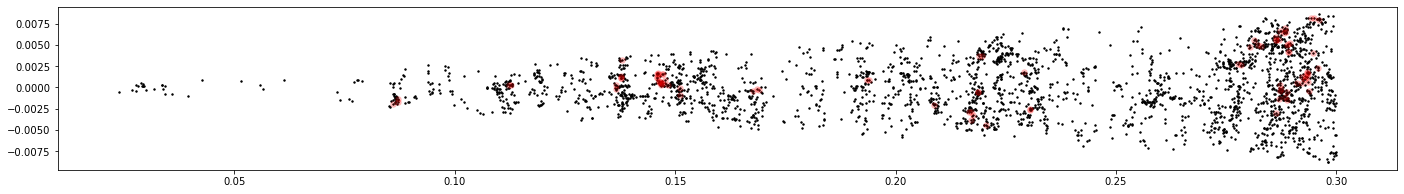

In [22]:
plt.figure(figsize=(24,3))
plt.scatter(data['Z'], data['Z']*np.deg2rad(data['RA']-np.mean(data['RA'])), s=2, c='black')#, cmap='seismic')
ii = data['P_PEAK']>0.5
plt.scatter(data['Z'][ii], data['Z'][ii]*np.deg2rad(data['RA'][ii]-np.mean(data['RA'])), s=30, c='red', alpha=0.2)#, cmap='seismic')


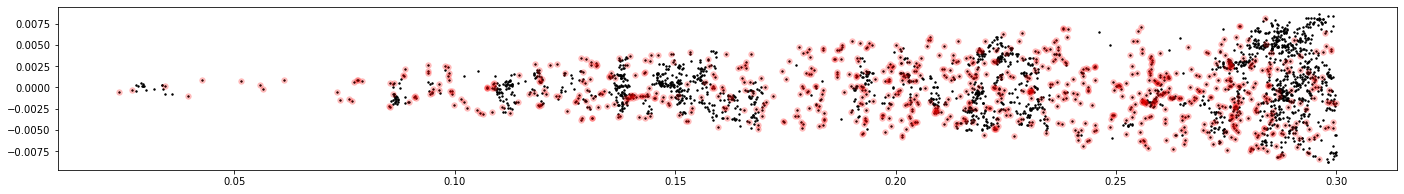

In [23]:
plt.figure(figsize=(24,3))
plt.scatter(data['Z'], data['Z']*np.deg2rad(data['RA']-np.mean(data['RA'])), s=2, c='black')#, cmap='seismic')
ii = data['P_SHEET']>0.5
plt.scatter(data['Z'][ii], data['Z'][ii]*np.deg2rad(data['RA'][ii]-np.mean(data['RA'])), s=30, c='red', alpha=0.2)#, cmap='seismic')
